# Module 2 — 2.7(A): Hands-On — Housing Regression

**Goal:** End-to-end regression on a realistic (synthetic) housing dataset with *intentional messiness*.

**Steps**
1) Generate & inspect
2) Clean & prepare 
3) Train/Test Split 
4) OLS baseline  
5) Polynomial (deg 2/3)  
6) Ridge/Lasso/ElasticNet  
7) Metrics (RMSE/MAE/R²/MAPE)  
8) GridSearchCV  
9) Reflection


## 0) Database Set-up

In [2]:
import numpy as np 
import pandas as pd

def make_housing_realistic(n=900, seed=1955, noise=20000):
    rng = np.random.default_rng(seed)
    sqft = np.clip(rng.normal(1800, 600, n), 450, 4200)
    beds = np.clip(np.round(sqft/800 + rng.normal(0,0.6,n)), 1, 6).astype(int)
    baths= np.clip(beds - 1 + rng.normal(0.2,0.5,n), 1, 4).round().astype(int)
    age  = np.clip(rng.gamma(2.0,12.0,n), 0, 120)
    lot  = np.clip((sqft/5000)+rng.lognormal(-3.2,0.4,n), 0.03, 1.5)
    dist = np.clip(rng.lognormal(2.3,0.5,n), 0.5, 45)
    base, c_sq,c_b,c_ba,c_a,c_l,c_d = 75000,130,12000,9000,-400,85000,-2800
    inter = 0.02*sqft/np.sqrt(dist)
    eps   = rng.normal(0, noise+0.02*sqft, n)
    price = (base + c_sq*sqft + c_b*beds + c_ba*baths + c_a*age + c_l*lot + c_d*dist + inter + eps)
    df = pd.DataFrame({'sqft':sqft.round(0),'bedrooms':beds,'bathrooms':baths,
                       'age_years':age.round(0),'lot_size':lot.round(3),
                       'dist_to_center_km':dist.round(2),'price':price.round(0)})
    # messiness: missing/invalids
    rng = np.random.default_rng(seed+1)
    df.loc[rng.random(n)<0.08,'sqft']=np.nan
    df.loc[rng.random(n)<0.05,'lot_size']=np.nan
    bad = df.sample(3, random_state=seed+2).index
    df.loc[bad,'sqft']=[0,-50,12000]
    df.loc[df.sample(2, random_state=seed+3).index,'dist_to_center_km']=[0,999]
    df.loc[rng.random(n)<0.02,'price']=np.nan
    return df


## 1) Generate & inspect

In [3]:
# --- 1) Generate & inspect ---
df = make_housing_realistic()
df.head()


,sqft,bedrooms,bathrooms,age_years,lot_size,dist_to_center_km,price
0,2148.0,4,3,13.0,0.494,3.66,450390.0
1,1908.0,2,1,23.0,NaN,3.65,375746.0
2,2368.0,2,2,77.0,0.502,12.37,394964.0
3,2916.0,4,4,6.0,0.649,12.66,561309.0
4,1208.0,1,1,8.0,0.270,4.96,280848.0


**Sanity-check:** column names, types, rough ranges, missing values, and impossible values (e.g., `sqft` ≤ 0).

In [4]:
df.info() 
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sqft               821 non-null    float64
 1   bedrooms           900 non-null    int64  
 2   bathrooms          900 non-null    int64  
 3   age_years          900 non-null    float64
 4   lot_size           848 non-null    float64
 5   dist_to_center_km  900 non-null    float64
 6   price              878 non-null    float64
dtypes: float64(5), int64(2)
memory usage: 49.3 KB


,sqft,bedrooms,bathrooms,age_years,lot_size,dist_to_center_km,price
count,821.000000,900.000000,900.000000,900.000000,848.000000,900.000000,878.000000
mean,1834.535932,2.337778,1.750000,23.412222,0.410336,12.123856,350830.318907
std,695.998068,0.954653,0.900346,16.700198,0.120428,33.497648,105473.843947
min,-50.000000,1.000000,1.000000,1.000000,0.115000,0.000000,89611.000000
25%,1398.000000,2.000000,1.000000,11.000000,0.327000,6.895000,276939.500000
50%,1830.000000,2.000000,1.000000,20.000000,0.415500,9.670000,350419.000000
75%,2263.000000,3.000000,2.000000,32.000000,0.494000,13.645000,426597.000000
max,12000.000000,6.000000,4.000000,110.000000,0.732000,999.000000,735069.000000


## 2) Clean & prepare

We will clean missing/invalid values next.

In [5]:
# --- 2) Clean & prepare ---
from sklearn.impute import SimpleImputer

# drop rows with missing target
df = df.dropna(subset=['price']).copy()
# mark invalids as NaN
df.loc[df['sqft']<=0,'sqft']=np.nan
df.loc[df['dist_to_center_km']<=0,'dist_to_center_km']=np.nan
# median impute numeric predictors
num_cols=['sqft','bedrooms','bathrooms','age_years','lot_size','dist_to_center_km']
imp = SimpleImputer(strategy='median')
df[num_cols] = imp.fit_transform(df[num_cols])
df.head()


,sqft,bedrooms,bathrooms,age_years,lot_size,dist_to_center_km,price
0,2148.0,4.0,3.0,13.0,0.494,3.66,450390.0
1,1908.0,2.0,1.0,23.0,0.414,3.65,375746.0
2,2368.0,2.0,2.0,77.0,0.502,12.37,394964.0
3,2916.0,4.0,4.0,6.0,0.649,12.66,561309.0
4,1208.0,1.0,1.0,8.0,0.270,4.96,280848.0


**Why:** Models need complete numeric inputs. We drop missing targets, convert invalid entries to `NaN`, and impute medians for robustness.

## 3) Train/Test Split 

In [6]:
# --- 3) Train/test split ---
from sklearn.model_selection import train_test_split
X = df.drop('price', axis=1) 
y = df['price']
Xtr,Xte,ytr,yte = train_test_split(X,y,test_size=0.2,random_state=1955)
Xtr.shape, Xte.shape


((702, 6), (176, 6))

Hold out ~20% for an unbiased evaluation of generalization.

## 4) OLS baseline   

In [7]:
# --- 4) Baseline OLS ---
#import pandas as pd
from sklearn.linear_model import LinearRegression
ols = LinearRegression()

ols.fit(Xtr,ytr)
yhat_ols = ols.predict(Xte)

pd.Series(ols.coef_, index=Xtr.columns).sort_values()


age_years              -447.514377
dist_to_center_km       -67.407559
sqft                     16.233363
bathrooms             12027.486122
bedrooms              21969.624992
lot_size             574190.466109
dtype: float64

**Coefficients:** Positive → increases price; negative → decreases price (holding others fixed).

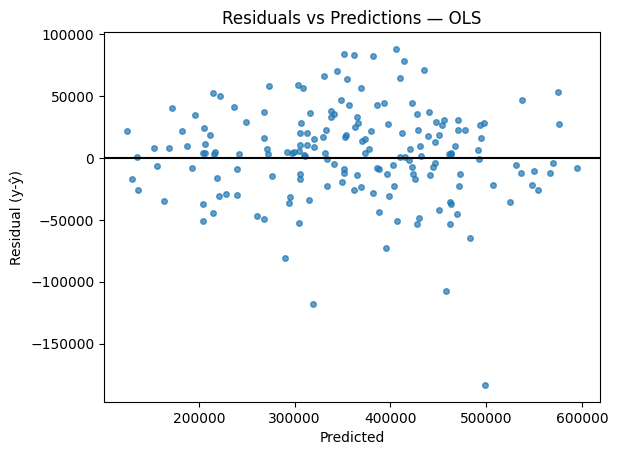

OLS metrics:
RMSE: 37775.45012486355
MAE : 28052.23395326375
R²  : 0.884901705820043
MAPE: 8.62%


In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

resid = yte - yhat_ols
plt.scatter(yhat_ols, resid, s=16, alpha=0.7)
plt.axhline(0,color='k') 
plt.xlabel('Predicted') 
plt.ylabel('Residual (y-ŷ)')
plt.title('Residuals vs Predictions — OLS') 
plt.show()


def mape(y_true, y_pred, eps=1e-9):
    yt=np.asarray(y_true,float) 
    yp=np.asarray(y_pred,float) 
    m=np.abs(yt)>eps
    return np.mean(np.abs((yt[m]-yp[m])/(yt[m]+eps)))*100 if m.any() else np.nan
print('OLS metrics:')
print('RMSE:', np.sqrt(mean_squared_error(yte,yhat_ols)))
print('MAE :', mean_absolute_error(yte,yhat_ols))
print('R²  :', r2_score(yte,yhat_ols))
print('MAPE:', f"{mape(yte,yhat_ols):.2f}%")


Flat residual band is good; patterns suggest nonlinearities or variance issues.

## 5) Polynomial (deg 2/3) 

In [9]:
# --- 5) Polynomial models (deg 2 & 3) ---
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

poly2 = make_pipeline(PolynomialFeatures(2, include_bias=False), LinearRegression())
poly3 = make_pipeline(PolynomialFeatures(3, include_bias=False), LinearRegression())
poly2.fit(Xtr,ytr) 
yhat_p2 = poly2.predict(Xte)
poly3.fit(Xtr,ytr) 
yhat_p3 = poly3.predict(Xte)

def summarize(name, y_true, y_pred):
    return {
        'Model': name,
        'RMSE' : np.sqrt(mean_squared_error(y_true,y_pred)),
        'MAE'  : mean_absolute_error(y_true,y_pred),
        'R2'   : r2_score(y_true,y_pred),
        'MAPE%': mape(y_true,y_pred)
    }

pd.DataFrame([
    summarize('OLS', yte, yhat_ols),
    summarize('Poly deg=2', yte, yhat_p2),
    summarize('Poly deg=3', yte, yhat_p3),
]).sort_values('RMSE')


,Model,RMSE,MAE,R2,MAPE%
2,Poly deg=3,27188.632886,19922.685669,0.940376,6.061803
1,Poly deg=2,30645.307441,21966.333752,0.924251,6.448535
0,OLS,37775.450125,28052.233953,0.884902,8.623902


**PolynomialFeatures** creates curved/interaction terms. Compare metrics; watch for overfitting (deg 3).

## 6) Ridge/Lasso/ElasticNet  

In [10]:
# --- 6) Regularization: Ridge / Lasso / ElasticNet ---
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler

ridge = make_pipeline(StandardScaler(), Ridge(alpha=1.0, random_state=1955))
lasso = make_pipeline(StandardScaler(), Lasso(alpha=0.1, random_state=1955, max_iter=10000))
enet  = make_pipeline(StandardScaler(), ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=1955, max_iter=10000))

pd.DataFrame([
    summarize('Ridge', yte, ridge.fit(Xtr,ytr).predict(Xte)),
    summarize('Lasso', yte, lasso.fit(Xtr,ytr).predict(Xte)),
    summarize('ElasticNet', yte, enet.fit(Xtr,ytr).predict(Xte)),
]).sort_values('RMSE')


,Model,RMSE,MAE,R2,MAPE%
0,Ridge,37770.540520,28049.404821,0.884932,8.622986
1,Lasso,37775.458570,28052.236953,0.884902,8.623904
2,ElasticNet,37785.909526,28079.255406,0.884838,8.667330


**Why regularize?** Stabilize coefficients, combat multicollinearity, temper high-variance fits.

## 7) Metrics (RMSE/MAE/R²/MAPE)  

In [11]:
# --- Step 7: Compare Metrics Across All Models ---

import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def evaluate_model(name, model):
    """Return a row of metrics for a given model."""
    pred = model.predict(Xte)
    rmse = np.sqrt(mean_squared_error(yte, pred))
    mae  = mean_absolute_error(yte, pred)
    r2   = r2_score(yte, pred)
    mp   = mape(yte, pred)
    return {"Model": name, "RMSE": rmse, "MAE": mae, "R²": r2, "MAPE%": mp}

# Gather metrics for all models
results = [
    evaluate_model("OLS", ols),
    evaluate_model("Poly deg=2", poly2),
    evaluate_model("Poly deg=3", poly3),
    evaluate_model("Ridge", ridge),
    evaluate_model("Lasso", lasso),
    evaluate_model("ElasticNet", enet)
]

metrics_df = pd.DataFrame(results).sort_values("RMSE")
metrics_df


,Model,RMSE,MAE,R²,MAPE%
2,Poly deg=3,27188.632886,19922.685669,0.940376,6.061803
1,Poly deg=2,30645.307441,21966.333752,0.924251,6.448535
3,Ridge,37770.540520,28049.404821,0.884932,8.622986
0,OLS,37775.450125,28052.233953,0.884902,8.623902
4,Lasso,37775.458570,28052.236953,0.884902,8.623904
5,ElasticNet,37785.909526,28079.255406,0.884838,8.667330


## 8) GridSearchCV 

In [12]:
# --- 8) GridSearchCV for Ridge α ---
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

ridge_pipe = Pipeline([('scale', StandardScaler()), ('ridge', Ridge(random_state=1955))])
params = {'ridge__alpha': [0.01, 0.1, 1, 10, 100]}
gs = GridSearchCV(ridge_pipe, param_grid=params, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
gs.fit(Xtr,ytr)
best = gs.best_estimator_
pred = best.predict(Xte)
print('Best alpha:', gs.best_params_['ridge__alpha'])
print('Best CV RMSE:', -gs.best_score_)
print('Test RMSE:', np.sqrt(mean_squared_error(yte,pred)))


Best alpha: 100
Best CV RMSE: 67303.65878227951
Test RMSE: 38357.58717878072


`GridSearchCV` tries multiple α values with CV and picks the best performer, then we evaluate on the held-out test set.

## 9) Reflection
- Which model performed best and why?
- Did polynomial terms help or overfit?
- Did regularization improve stability/performance?
- What feature engineering or transformations would you try next?
